In [1]:
"""
Run regressions that strip predictable components of consumption and income
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys; sys.path.append('/home/mitch/school/data/mexico_enigh/src/')
sys.path.append('/home/mitch/util/python/')
from stargazer.stargazer import Stargazer

import mpl

import utils
import os

import statsmodels.stats.weightstats as ws

plotdir = '/home/mitch/school/data/mexico_enigh/fig/'

processed = '/home/mitch/Dropbox/data/mexico_enigh/processed/'

save = False


In [2]:
os.chdir(processed)
df = pd.read_csv('data.csv')

/home/mitch/anaconda3/envs/main/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (92,101,254,305,306,314,319,324) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df.Y.unique()

array([1992, 1994, 1996, 1998, 2000, 2002, 2004, 2006, 2008])

In [4]:
cpidir = '/home/mitch/Dropbox/data/cpi/'
os.chdir(cpidir)
cpi = pd.read_csv('cpi_annual.csv')
cpi = cpi.rename(columns = {'time':'Y', 'PCPI_IX':'cpi'})
cpi = cpi.query('country == "MX"')
cpi = cpi.drop(columns=['Unnamed: 0', 'country'])

In [5]:
df = df.merge(cpi, on='Y', how='inner')

In [6]:
# don't include: other income
# transfers
# rental income

# do include:
# salary income
# business income

is1992 = df['Y'] == 1992

#income = ['salary_income', 'business_income', 'transfers_income']
income = ['income_salary', 'income_business', 'income_transfers']
df['income'] = df[income].sum(axis=1)
df['income'] = df['income'] / df['cpi']
df['income'] = df['income'] / df['hh_size']
df.loc[is1992, 'income'] = df.loc[is1992, 'income'] / 1000
df['log_income'] = np.log(df['income'])

consumption = ['consumption_food', 'consumption_personal', 'consumption_clothing']
#consumption = ['consumption_food', 'consumption_clothing', 'consumption_personal', 'consumption_education']
df['consumption'] = df[consumption].sum(axis=1)
df['consumption'] = df['consumption'] / df['cpi']
df['consumption'] = df['consumption'] / df['hh_size']
df.loc[is1992, 'consumption'] = df.loc[is1992, 'consumption'] / 1000
df['log_consumption'] = np.log(df['consumption'])

/home/mitch/anaconda3/envs/main/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
df.Y.unique()

array([1992, 1994, 1996, 1998, 2000, 2002, 2004, 2006, 2008])

In [8]:
df.query('Y == 1994')['relationship_to_hhm'].unique()

array([1, 2])

In [9]:
df['ishhm']

0         True
1         True
2         True
3         True
4         True
          ... 
149887    True
149888    True
149889    True
149890    True
149891    True
Name: ishhm, Length: 149892, dtype: bool

In [10]:
df = df.query('ishhm == 1')
df = df.query('income > 0')
df = df.query('consumption > 0')
df = df.query('age >= 25')
df = df.query('age <= 60')
#df = df[df['location_size'].apply(lambda x : x not in [4.0, 5.0])]

In [11]:
df.Y.unique()

array([1992, 1994, 1996, 1998, 2000, 2002, 2004, 2006, 2008])

In [12]:
consumption_to_income = ws.DescrStatsW(df['consumption'] / df['income'], weights=df['weight'])
consumption_to_income_005 = consumption_to_income.quantile(0.005)
consumption_to_income_995 = consumption_to_income.quantile(0.995)
df = df[df['consumption'] / df['income'] > consumption_to_income_005.values[0]]
df = df[df['consumption'] / df['income'] < consumption_to_income_995.values[0]]

In [15]:
df['log_income_weighted'] = df['log_income'] * df['weight']

In [16]:
aux = df.groupby('Y')['log_income_weighted'].mean()

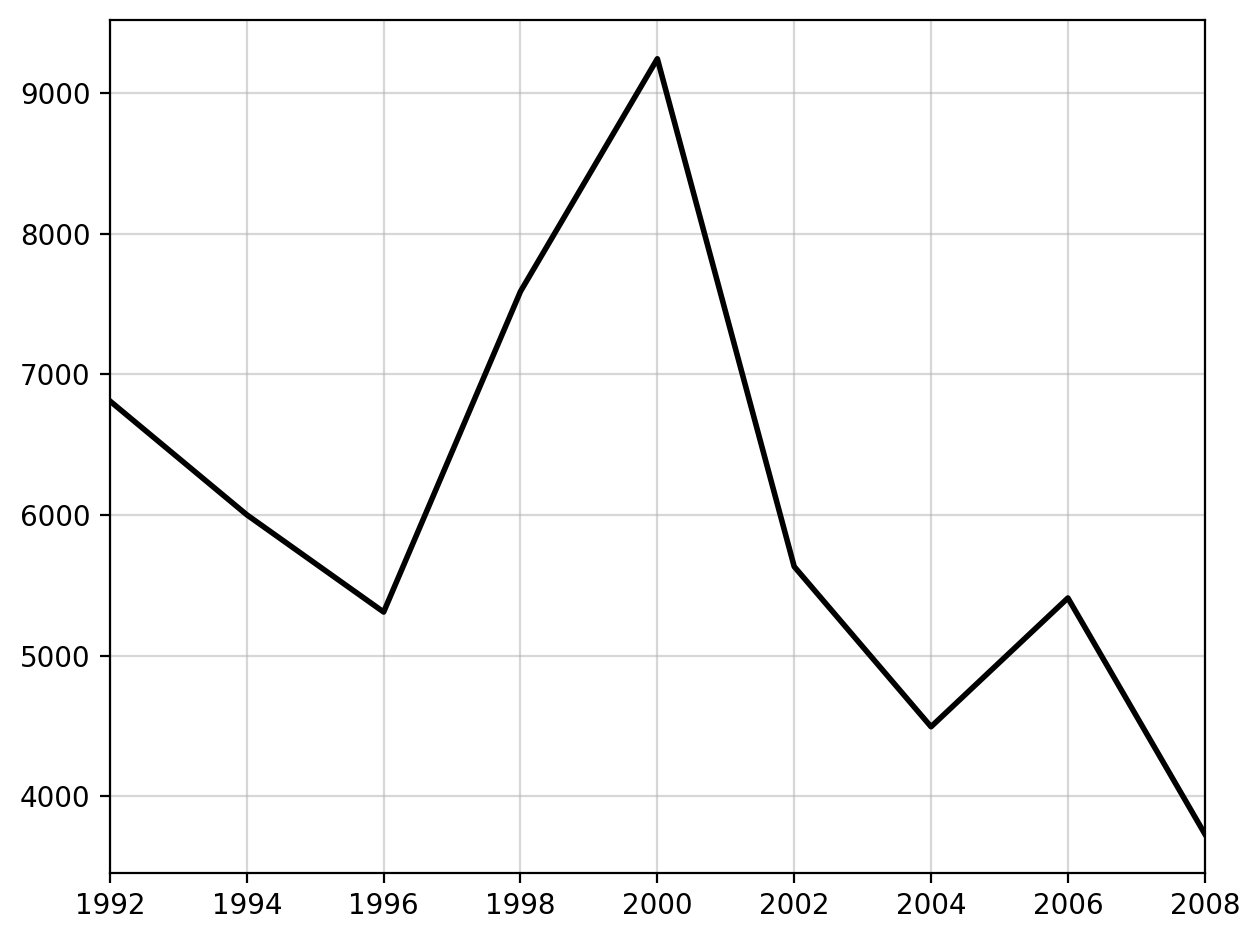

In [17]:
plt.clf()
plt.plot(aux)
plt.show()

In [20]:
byyear = {}
for year in df.Y.unique():
    focus = df.query('Y == @year')
    income_weighted = np.sum(focus['log_income'] * focus['weight']) / (len(focus) * focus['weight'].sum())
    byyear[year] = income_weighted

In [21]:
byyear

{1992: 0.00048484400041204557,
 1994: 0.0004067585248699124,
 1996: 0.0003382671681855516,
 1998: 0.0004532861231115196,
 2000: 0.0005174725826555775,
 2002: 0.00030524126086990065,
 2004: 0.00023667965238958149,
 2006: 0.00026681271278327913,
 2008: 0.00017781443312891225}

In [25]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.weightstats as ws

from statsmodels.genmod.families.links import identity
fam = sm.families.Gaussian(identity())

df = df.query('Y >= 1994').query('Y <= 1996')
df['post'] = df.Y == 1996

df['weight_income'] = df['weight'] * df['income']

Z = 'post'
income_reg = 'log_income ~ ' + Z 
income_model = smf.glm(income_reg, df, freq_weights=df['weight_income'], missing='drop', family=fam).fit()
income_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             log_income   No. Observations:                20262
Model:                            GLM   Df Residuals:            2298216707.15
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          1.3624
Method:                          IRLS   Log-Likelihood:            -3.6164e+09
Date:                Fri, 17 Nov 2023   Deviance:                   3.1310e+09
Time:                        13:38:36   Pearson chi2:                 3.13e+09
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        5.1292   3.24e-05   1.59e+05      0.000       5.129       5.129
post[T.True]    -0.3922   4.91e-05  -7983.518      0.000      -0.392      -0.392
================================================================================
"""

In [226]:

deciles = []
for Y in np.sort(df.Y.unique()):
    data = df.query('Y == @Y')[['hhid', 'income', 'weight']]
    data['decile'] = utils.get_deciles(data['income'], data['weight'])
    data['Y'] = Y
    deciles.append(data)
deciles = pd.concat(deciles)
    

In [227]:
df = df.merge(deciles[['hhid', 'Y', 'decile']], on=['hhid', 'Y'], how='outer')
df

,hhid,location,weight,location_size,ingmon,permon,gasnom,eronom,income_current,gasmon,...,bustrab_5,bustrab_6,bustrab_7,cpi,income,log_income,consumption,log_consumption,post,decile
0,19940110010,1001,169.0,1,6480.0,0.0,920.31,1680.0,7400.31,5062.41,...,NaN,NaN,NaN,19.551304,36.826188,3.606209,12.826595,2.551521,False,5
1,19940110030,1001,169.0,1,2760.0,0.0,593.54,0.0,3353.54,2002.79,...,NaN,NaN,NaN,19.551304,47.055685,3.851332,24.818805,3.211602,False,6
2,19940110040,1001,169.0,1,6600.0,0.0,1533.85,0.0,8133.85,4925.66,...,NaN,NaN,NaN,19.551304,56.262232,4.030023,23.500223,3.157010,False,6
3,19940110060,1001,153.0,1,7560.0,200.0,1305.79,0.0,8865.79,4109.89,...,NaN,NaN,NaN,19.551304,77.334995,4.348147,22.068809,3.094165,False,8
4,19940110070,1001,153.0,1,13000.0,500.0,3185.04,0.0,16185.04,11161.73,...,NaN,NaN,NaN,19.551304,110.819548,4.707903,58.902636,4.075886,False,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20257,19963399020,15033,1351.0,1,4800.0,0.0,306.67,0.0,5106.67,4182.13,...,NaN,NaN,NaN,35.467989,33.833325,3.521446,17.261058,2.848453,True,5
20258,19963399030,15033,1351.0,1,2950.0,0.0,1257.35,0.0,4207.35,2359.12,...,NaN,NaN,NaN,35.467989,20.793398,3.034636,9.475728,2.248734,True,3
20259,19963399040,15033,1351.0,1,2650.0,200.0,920.01,0.0,3570.01,2046.06,...,NaN,NaN,NaN,35.467989,10.673609,2.367774,5.710783,1.742356,True,1
20260,19963399060,15109,1077.0,2,5280.0,500.0,3610.95,0.0,8890.95,5860.77,...,NaN,NaN,NaN,35.467989,49.622210,3.904439,38.139556,3.641252,True,7


In [228]:
params = ['post[T.True]:C(decile)[' + str(x) + ']' for x in np.arange(1, 11) ]

In [229]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.weightstats as ws

from statsmodels.genmod.families.links import identity
fam = sm.families.Gaussian(identity())

In [230]:
#Z = 'age + I(age**2) + C(sex) + C(education) + C(hh_size)  + C(location_size)'
Z = 'age + I(age**2) + C(sex) + C(education) + C(hh_size)  + C(location_size) + C(decile)'
D = 'post:C(decile) + post:C(education) + post:C(sex)'

income_reg = 'log_income ~ ' + Z + '+' + D
income_model = smf.glm(income_reg, df, freq_weights=df['weight'], missing='drop', family=fam).fit()

In [231]:
import statsmodels.formula.api as smf
import statsmodels.stats.weightstats as ws
#Z = 'age + I(age**2) + C(sex) + C(education) + C(hh_size)  + C(location_size)'
Z = 'age + I(age**2) + C(sex) + C(education) + C(hh_size)  + C(location_size) + C(decile)'
D = 'post:C(decile) + post:C(education) + post:C(sex)'
#D = 'post:C(education) + post:C(sex)'

consumption_reg = 'log_consumption ~ ' + Z + '+' + D
consumption_model = smf.glm(consumption_reg, df, freq_weights=df['weight'], missing='drop', family=fam).fit()

In [232]:
consumption_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        log_consumption   No. Observations:                20262
Model:                            GLM   Df Residuals:                 30451676
Model Family:                Gaussian   Df Model:                           51
Link Function:               identity   Scale:                         0.22241
Method:                          IRLS   Log-Likelihood:            -2.0321e+07
Date:                Fri, 10 Nov 2023   Deviance:                   6.7726e+06
Time:                        16:30:20   Pearson chi2:                 6.77e+06
No. Iterations:                     4   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               2.6758      0.002   1477.599      0.000       2.672       2.679
C(sex)[T.2]                            -0.0060      0.000    -15.819      0.000      -0.007      -0.005
C(education)[T.low]                    -0.1669      0.000   -359.676      0.000      -0.168      -0.166
C(education)[T.medium]                 -0.0992      0.000   -219.402      0.000      -0.100      -0.098
C(hh_size)[T.2]                        -0.2776      0.001   -528.403      0.000      -0.279      -0.277
C(hh_size)[T.3]                        -0.4144      0.000   -840.549      0.000      -0.415      -0.413
C(hh_size)[T.4]                        -0.4564      0.000   -947.812      0.000      -0.457      -0.455
C(hh_size)[T.5]                        -0.5396      0.000  -1093.891      0.000      -0.541      -0.539
C(hh_size)[T.6]                        -0.5602      0.001  -1073.479      0.000      -0.561      -0.559
C(hh_size)[T.7]                        -0.5948      0.001  -1062.338      0.000      -0.596      -0.594
C(hh_size)[T.8]                        -0.6562      0.001  -1045.219      0.000      -0.657      -0.655
C(hh_size)[T.9]                        -0.7006      0.001   -978.098      0.000      -0.702      -0.699
C(hh_size)[T.10]                       -0.6667      0.001   -805.058      0.000      -0.668      -0.665
C(hh_size)[T.11]                       -0.6329      0.001   -623.901      0.000      -0.635      -0.631
C(hh_size)[T.12]                       -0.7599      0.001   -566.187      0.000      -0.763      -0.757
C(hh_size)[T.13]                       -0.6564      0.002   -412.709      0.000      -0.660      -0.653
C(hh_size)[T.14]                       -0.8394      0.003   -329.502      0.000      -0.844      -0.834
C(hh_size)[T.15]                       -0.7665      0.003   -302.509      0.000      -0.771      -0.761
C(hh_size)[T.16]                       -0.6351      0.005   -130.680      0.000      -0.645      -0.626
C(hh_size)[T.17]                       -0.5665      0.004   -133.558      0.000      -0.575      -0.558
C(hh_size)[T.18]                       -0.5675      0.016    -35.712      0.000      -0.599      -0.536
C(hh_size)[T.19]                       -0.7855      0.010    -75.527      0.000      -0.806      -0.765
C(hh_size)[T.20]                       -0.5129      0.014    -35.709      0.000      -0.541      -0.485
C(hh_size)[T.23]                       -0.7466      0.045    -16.677      0.000      -0.834      -0.659
C(hh_size)[T.27]                       -0.4291      0.048     -8.915      0.000      -0.523      -0.335
C(location_size)[T.2]                   0.0074      0.000     28.113      0.000       0.007       0.008
C(location_size)[T.3]                  -0.0196      0.000    -70.43

In [233]:
income_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             log_income   No. Observations:                20262
Model:                            GLM   Df Residuals:                 30451676
Model Family:                Gaussian   Df Model:                           51
Link Function:               identity   Scale:                        0.053009
Method:                          IRLS   Log-Likelihood:             1.5139e+06
Date:                Fri, 10 Nov 2023   Deviance:                   1.6142e+06
Time:                        16:30:21   Pearson chi2:                 1.61e+06
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               2.4023      0.001   2717.245      0.000       2.401       2.404
C(sex)[T.2]                            -0.0058      0.000    -31.582      0.000      -0.006      -0.005
C(education)[T.low]                    -0.1015      0.000   -447.783      0.000      -0.102      -0.101
C(education)[T.medium]                 -0.1004      0.000   -454.894      0.000      -0.101      -0.100
C(hh_size)[T.2]                        -0.0664      0.000   -258.743      0.000      -0.067      -0.066
C(hh_size)[T.3]                        -0.1044      0.000   -433.649      0.000      -0.105      -0.104
C(hh_size)[T.4]                        -0.1020      0.000   -434.031      0.000      -0.102      -0.102
C(hh_size)[T.5]                        -0.1135      0.000   -471.172      0.000      -0.114      -0.113
C(hh_size)[T.6]                        -0.1225      0.000   -480.765      0.000      -0.123      -0.122
C(hh_size)[T.7]                        -0.1262      0.000   -461.581      0.000      -0.127      -0.126
C(hh_size)[T.8]                        -0.1331      0.000   -434.316      0.000      -0.134      -0.133
C(hh_size)[T.9]                        -0.1502      0.000   -429.420      0.000      -0.151      -0.149
C(hh_size)[T.10]                       -0.1416      0.000   -350.134      0.000      -0.142      -0.141
C(hh_size)[T.11]                       -0.1294      0.000   -261.291      0.000      -0.130      -0.128
C(hh_size)[T.12]                       -0.1912      0.001   -291.741      0.000      -0.192      -0.190
C(hh_size)[T.13]                       -0.1109      0.001   -142.862      0.000      -0.112      -0.109
C(hh_size)[T.14]                       -0.3165      0.001   -254.533      0.000      -0.319      -0.314
C(hh_size)[T.15]                       -0.1983      0.001   -160.285      0.000      -0.201      -0.196
C(hh_size)[T.16]                       -0.0854      0.002    -35.984      0.000      -0.090      -0.081
C(hh_size)[T.17]                       -0.1486      0.002    -71.784      0.000      -0.153      -0.145
C(hh_size)[T.18]                       -0.7398      0.008    -95.369      0.000      -0.755      -0.725
C(hh_size)[T.19]                        0.1144      0.005     22.530      0.000       0.104       0.124
C(hh_size)[T.20]                       -0.0189      0.007     -2.697      0.007      -0.033      -0.005
C(hh_size)[T.23]                       -0.0409      0.022     -1.870      0.061      -0.084       0.002
C(hh_size)[T.27]                       -0.0042      0.024     -0.180      0.857      -0.050       0.042
C(location_size)[T.2]                  -0.0123      0.000    -95.997      0.000      -0.013      -0.012
C(location_size)[T.3]                  -0.0176      0.000   -129.21

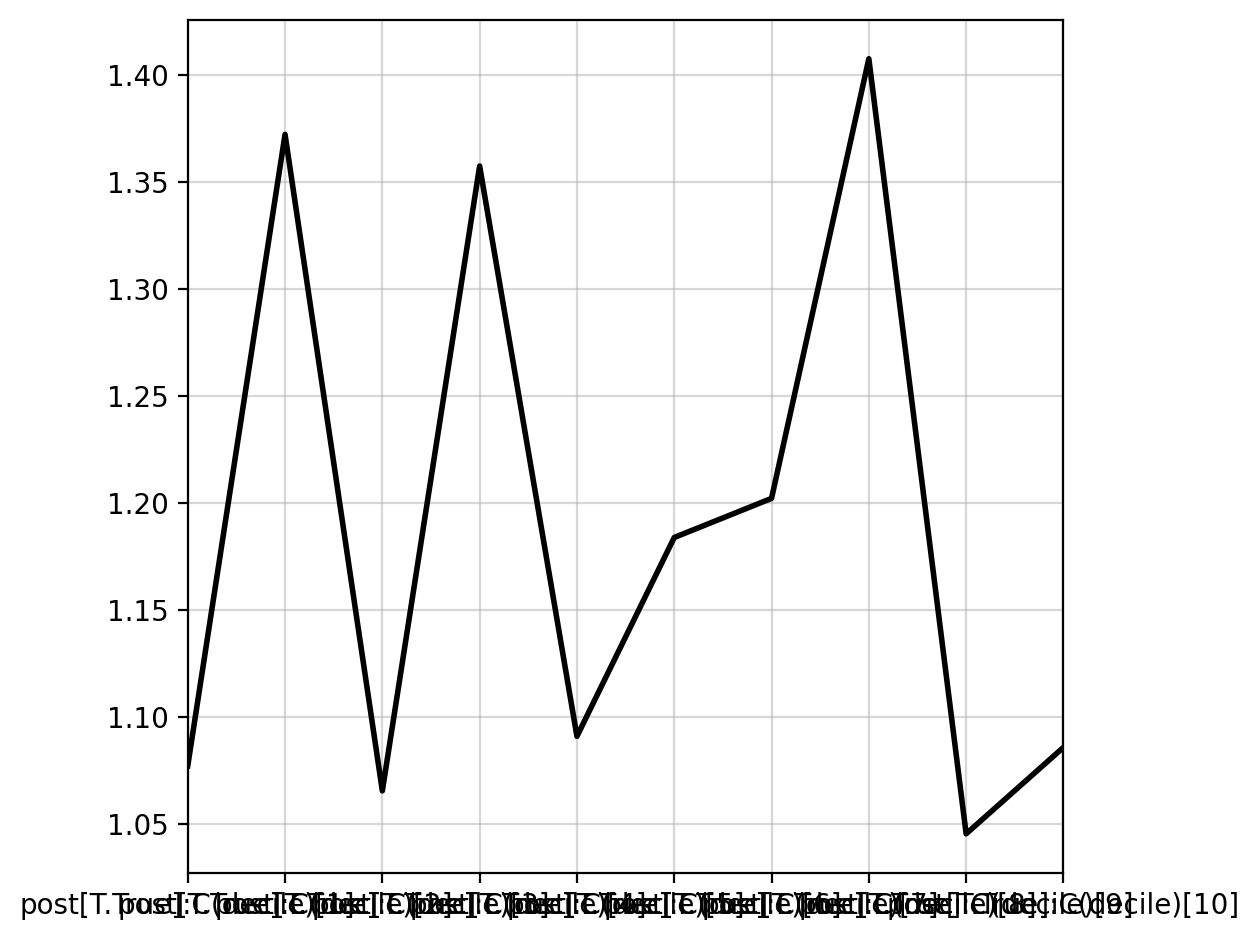

In [234]:
plt.clf()
plt.plot(income_model.params[params] / consumption_model.params[params])
plt.show()

In [235]:
nboot = 100
dconsumption = np.zeros((nboot, 10))
dincome = np.zeros((nboot, 10))
for boot in np.arange(nboot):
    # matters alot: double vs single resampling of the data
    # something tells me single sampling is correct
    # this is correct because: are matching the samples of the original data 
    # so should be all set 
    data_boot = df.copy().sample(len(data), weights=df['weight'], replace=True, axis=0)
    #data_boot = df.copy().sample(len(data), replace=True, axis=0)

    #consumption_model = smf.wls(consumption_reg, data_boot, weights=data_boot['weight']).fit()
    #consumption_model = smf.glm(consumption_reg, data_boot, freq_weights=data_boot['weight'], missing='drop', family=fam).fit()
    consumption_model = smf.glm(consumption_reg, data_boot, missing='drop', family=fam).fit()
    dconsumption[boot, :] = consumption_model.params[params]

    #income_model = smf.wls(income_reg, data_boot, weights=data_boot['weight']).fit()
    #income_model = smf.glm(income_reg, data_boot, freq_weights=data_boot['weight'],  missing='drop', family=fam).fit()
    income_model = smf.glm(income_reg, data_boot,  missing='drop', family=fam).fit()
    dincome[boot, :] = income_model.params[params]


In [236]:
deciles = np.arange(1, 11)

dconsumption_c10 = [np.quantile(dconsumption[:, ii], 0.10) for ii in np.arange(10)]
dconsumption_c90 = [np.quantile(dconsumption[:, ii], 0.90) for ii in np.arange(10)]
dconsumption_mean = [np.mean(dconsumption[:, ii]) for ii in np.arange(10)]

dincome_c10 = [np.quantile(dincome[:, ii], 0.10) for ii in np.arange(10)]
dincome_c90 = [np.quantile(dincome[:, ii], 0.90) for ii in np.arange(10)]
dincome_mean = [np.mean(dincome[:, ii]) for ii in np.arange(10)]


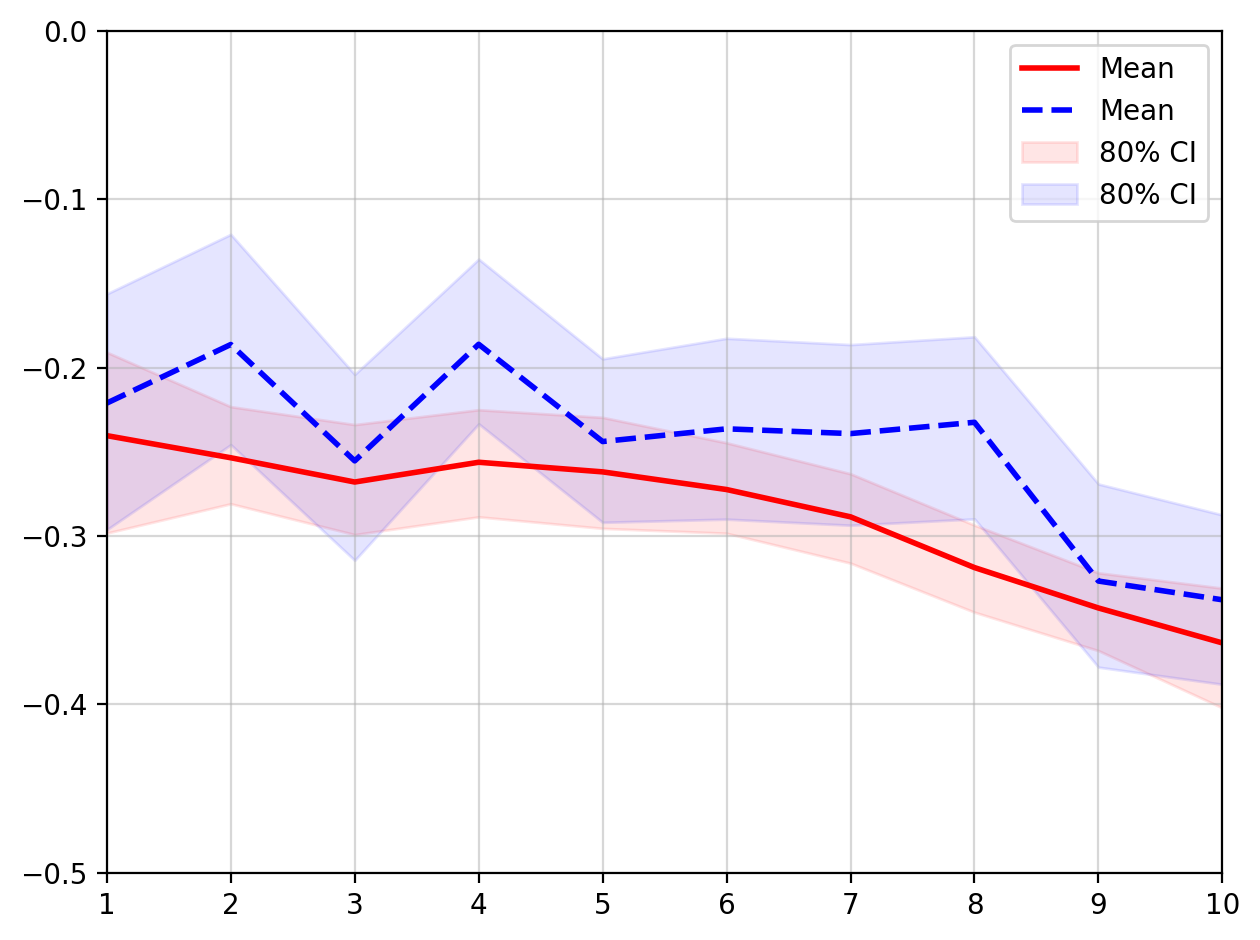

In [237]:


plt.clf()

plt.plot(deciles, dincome_mean, color='red', label='Mean')
plt.fill_between(deciles, dincome_c10, dincome_c90, color='red', alpha=0.10, label='80% CI')

plt.plot(deciles, dconsumption_mean, color='blue', label='Mean')
plt.fill_between(deciles, dconsumption_c10, dconsumption_c90, color='blue', alpha=0.10, label='80% CI')
plt.ylim(-0.5, 0)
plt.yticks(np.arange(-0.5, 0.1, 0.1))

plt.legend()


plt.gca().set_ylim(top=0)
plt.show()
#plt.plot(dconsumption_c10, label='lower')
#plt.plot(dconsumption_c90, label='upper')

<Figure size 1280x960 with 0 Axes>

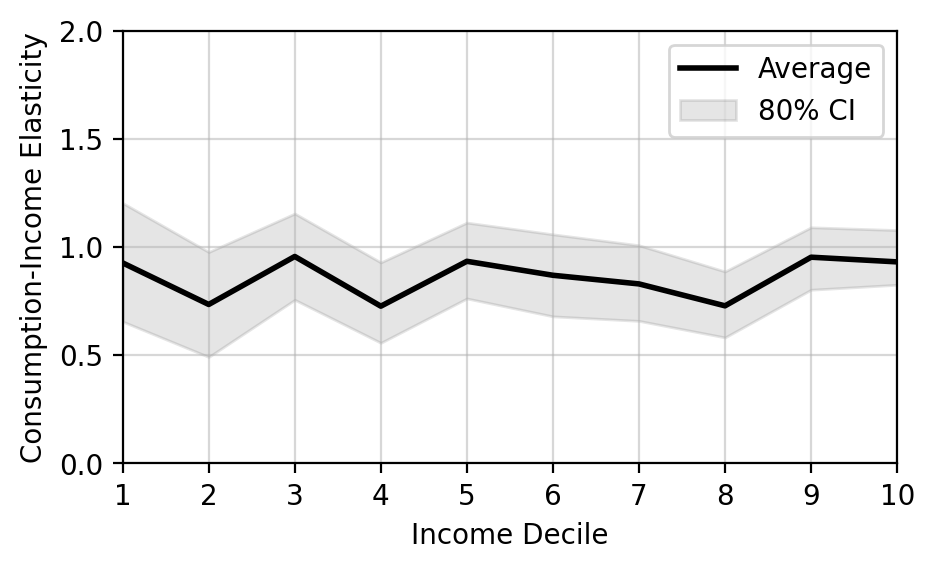

In [238]:
delasticity = dconsumption / dincome

plt.clf()
plt.figure(figsize = mpl.set_size())

delasticity_c10 = [np.quantile(delasticity[:, ii], 0.10) for ii in np.arange(10)]
delasticity_c90 = [np.quantile(delasticity[:, ii], 0.90) for ii in np.arange(10)]
delasticity_mean = [np.mean(delasticity[:, ii]) for ii in np.arange(10)]

plt.plot(deciles, delasticity_mean, label='Average', color='black')
plt.fill_between(deciles, delasticity_c10, delasticity_c90, color='black', alpha=0.10, label='80% CI')
plt.xlabel('Income Decile')
plt.ylim(0, 2.0)
plt.yticks(np.arange(0, 2.50, 0.50))
plt.ylabel('Consumption-Income Elasticity')

plt.legend()

if save:
    os.chdir(plotdir)
    #plt.savefig('elasticity_1994_1996_cugat_withci.png')
plt.show()
    

#plt.gca().set_ylim(top=0)

In [165]:
df[['relationship_to_hhm', 'ishhm']]

,relationship_to_hhm,ishhm
0,1,True
1,1,True
2,1,True
3,1,True
4,1,True
...,...,...
20340,1,True
20341,1,True
20342,1,True
20343,1,True


In [168]:
df['relationship_to_hhm'].value_counts()

1    19782
2      563
Name: relationship_to_hhm, dtype: int64

In [24]:
np.array(delasticity_mean).mean()

0.8653097410138247

In [30]:
out = pd.DataFrame()
out['mean'] = delasticity_mean
out['c10'] = delasticity_c10
out['c90'] = delasticity_c90
os.chdir(plotdir)
out.to_csv('enigh_elasticities.csv', index=False)


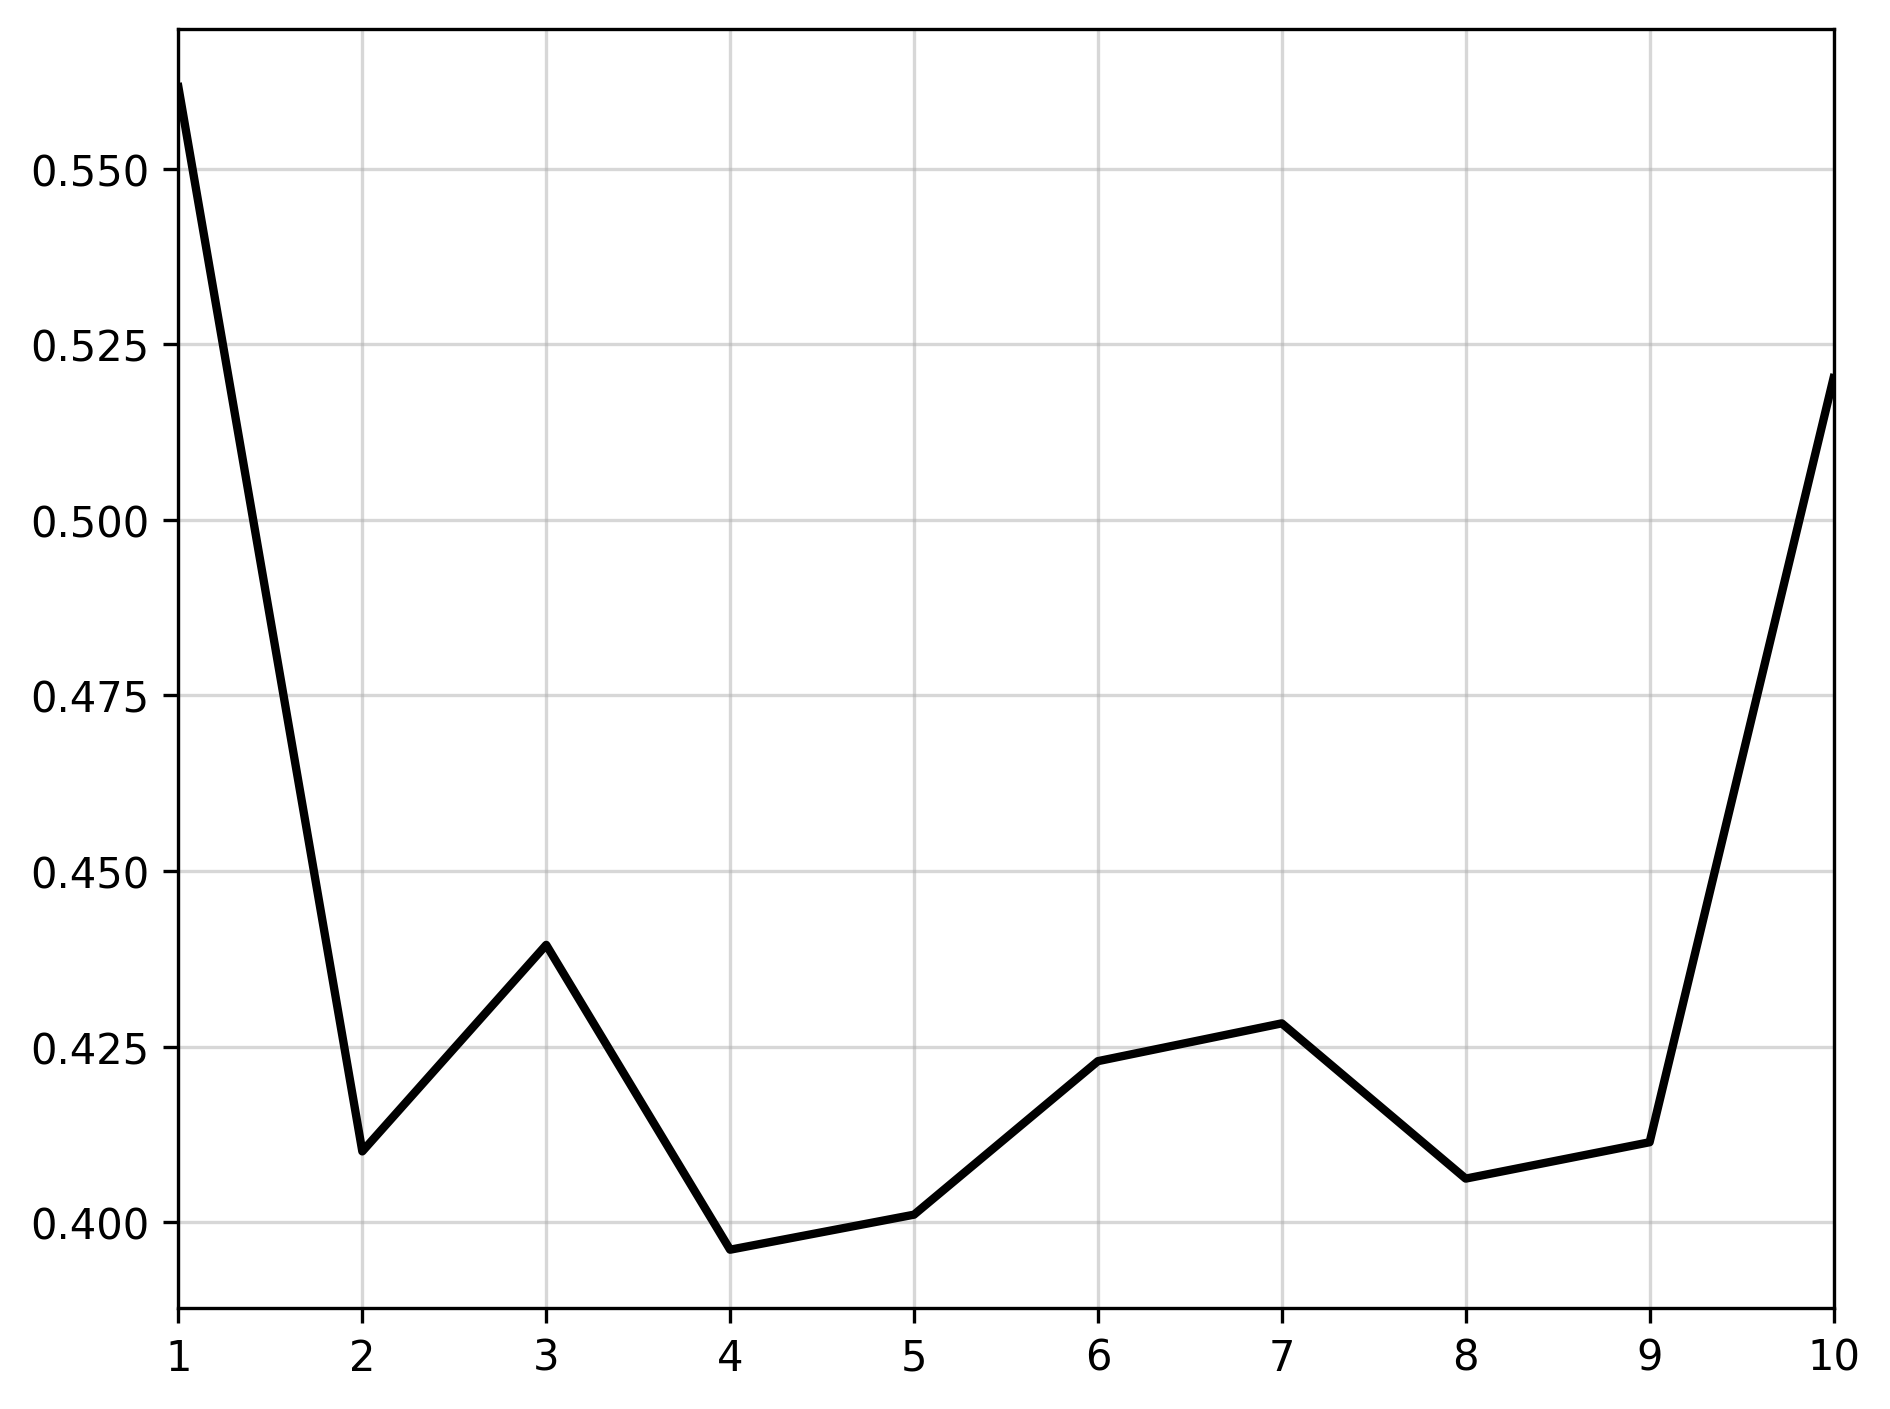

In [21]:
aux = consumption_model.resid_pearson.reset_index()
aux.columns = ['index', 'resid']
focus = df.reset_index().merge(aux, on=['index'], how='inner')

stds = focus[['decile', 'resid']].groupby('decile')['resid'].apply(np.std)
plt.clf()
plt.plot(stds)
plt.show()

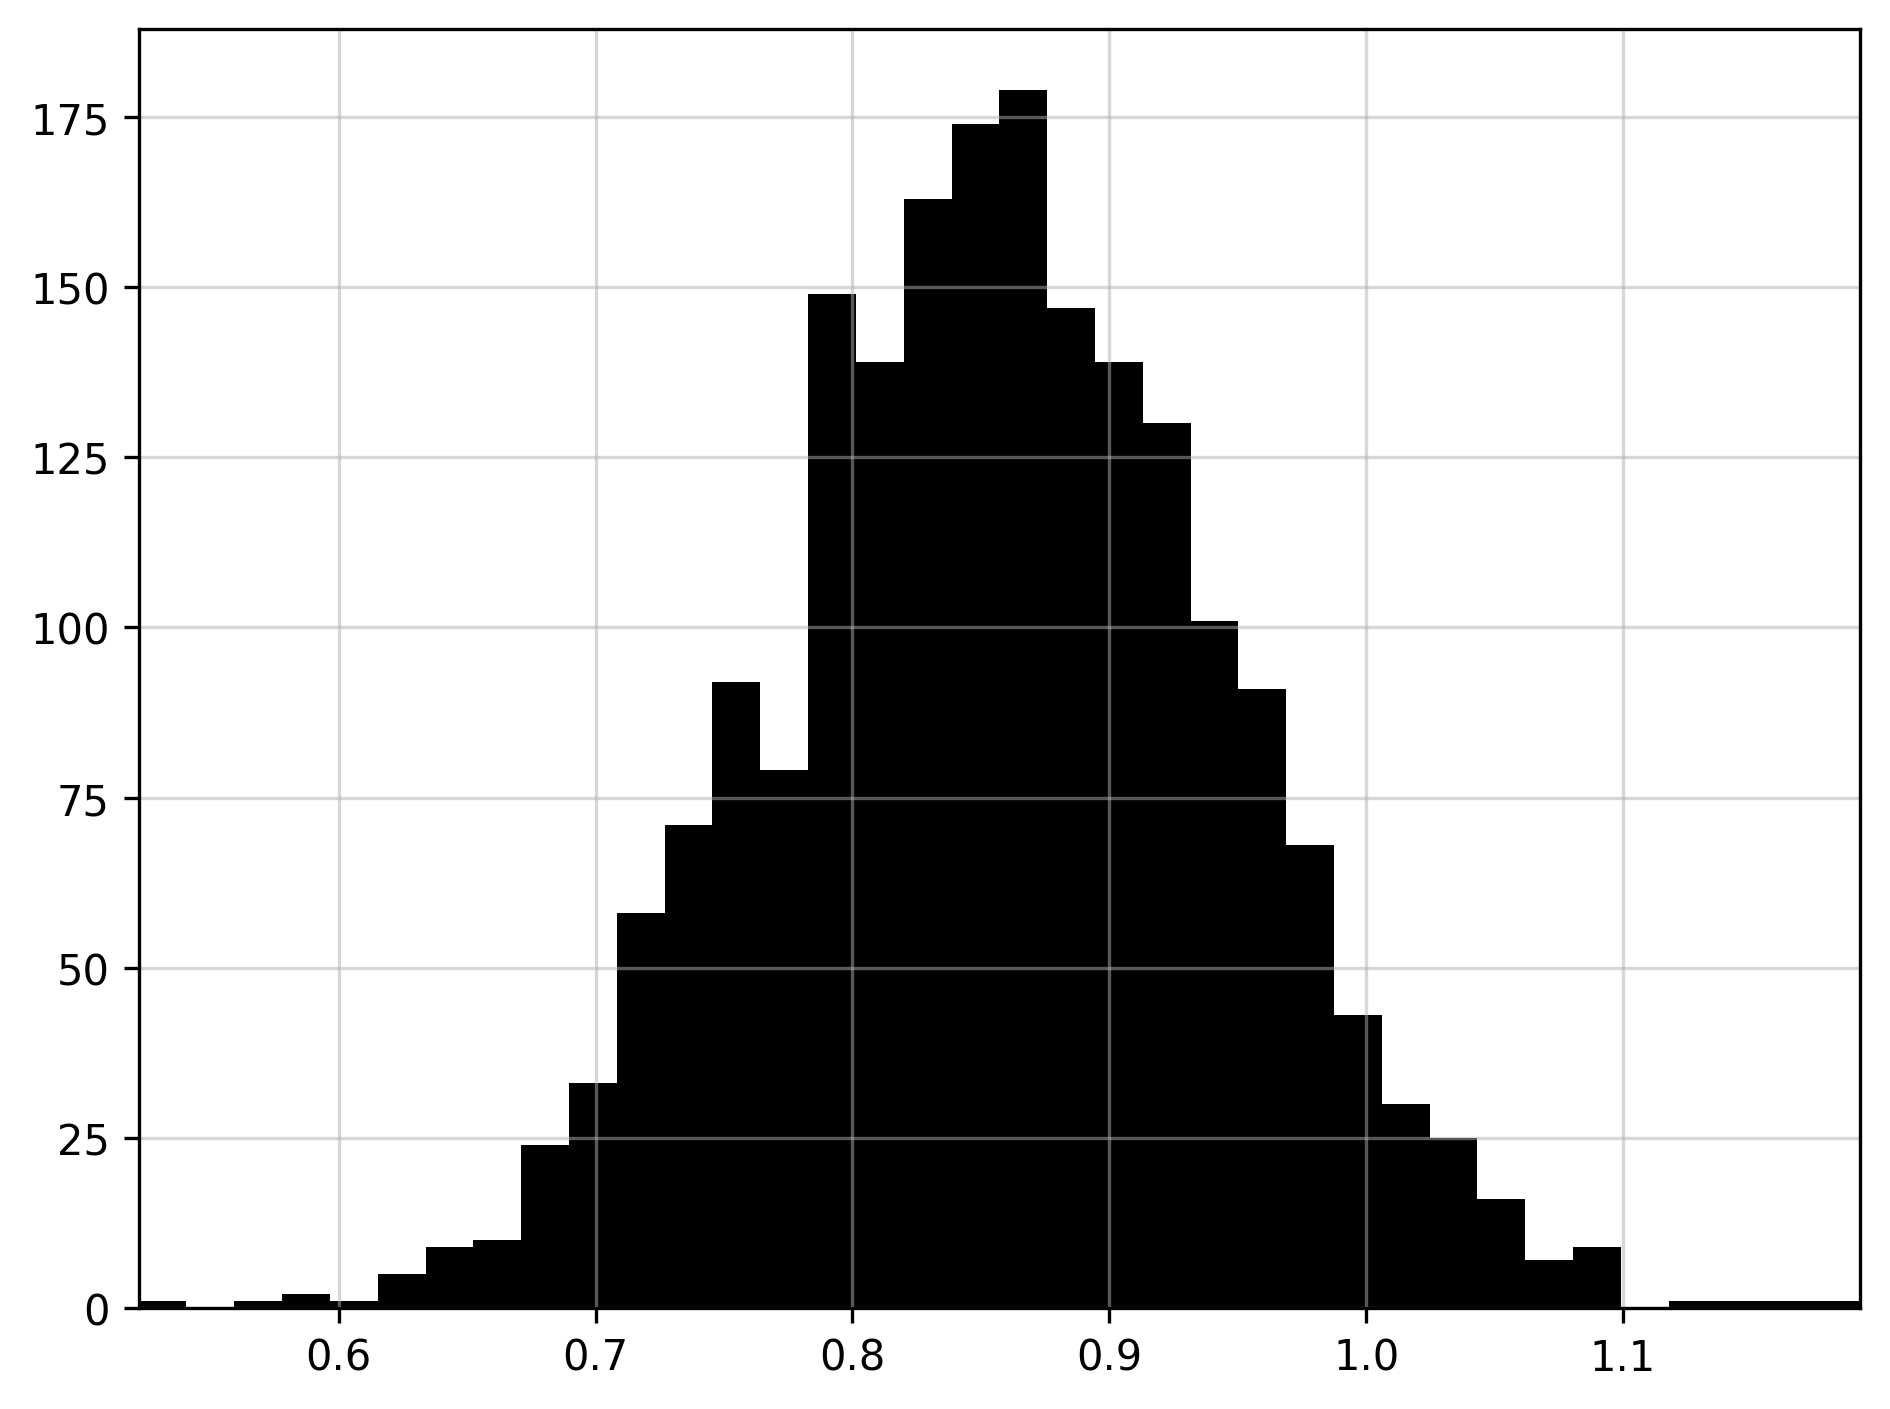

In [22]:
ii = 9
plt.clf()
plt.hist(delasticity[:, ii])
plt.show()

In [23]:
dconsumption = consumption_model.params[params]
#dincome = income_model.params[params]

In [24]:
dconsumption

post[T.True]:C(decile)[1]    -0.273182
post[T.True]:C(decile)[2]    -0.227252
post[T.True]:C(decile)[3]    -0.238836
post[T.True]:C(decile)[4]    -0.325205
post[T.True]:C(decile)[5]    -0.279040
post[T.True]:C(decile)[6]    -0.270084
post[T.True]:C(decile)[7]    -0.342472
post[T.True]:C(decile)[8]    -0.272311
post[T.True]:C(decile)[9]    -0.332470
post[T.True]:C(decile)[10]   -0.373757
dtype: float64

In [25]:
dconsumption_lb = consumption_model.conf_int().loc[params, 0]
dconsumption_ub = consumption_model.conf_int().loc[params, 1]
dincome_lb = income_model.conf_int().loc[params, 0]
dincome_ub = income_model.conf_int().loc[params, 1]

In [26]:
colors = {
    'C' : 'blue',
    'Y' : 'red'
}

ValueError: x and y must have same first dimension, but have shapes (10,) and (2000, 10)

<Figure size 1920x1440 with 0 Axes>

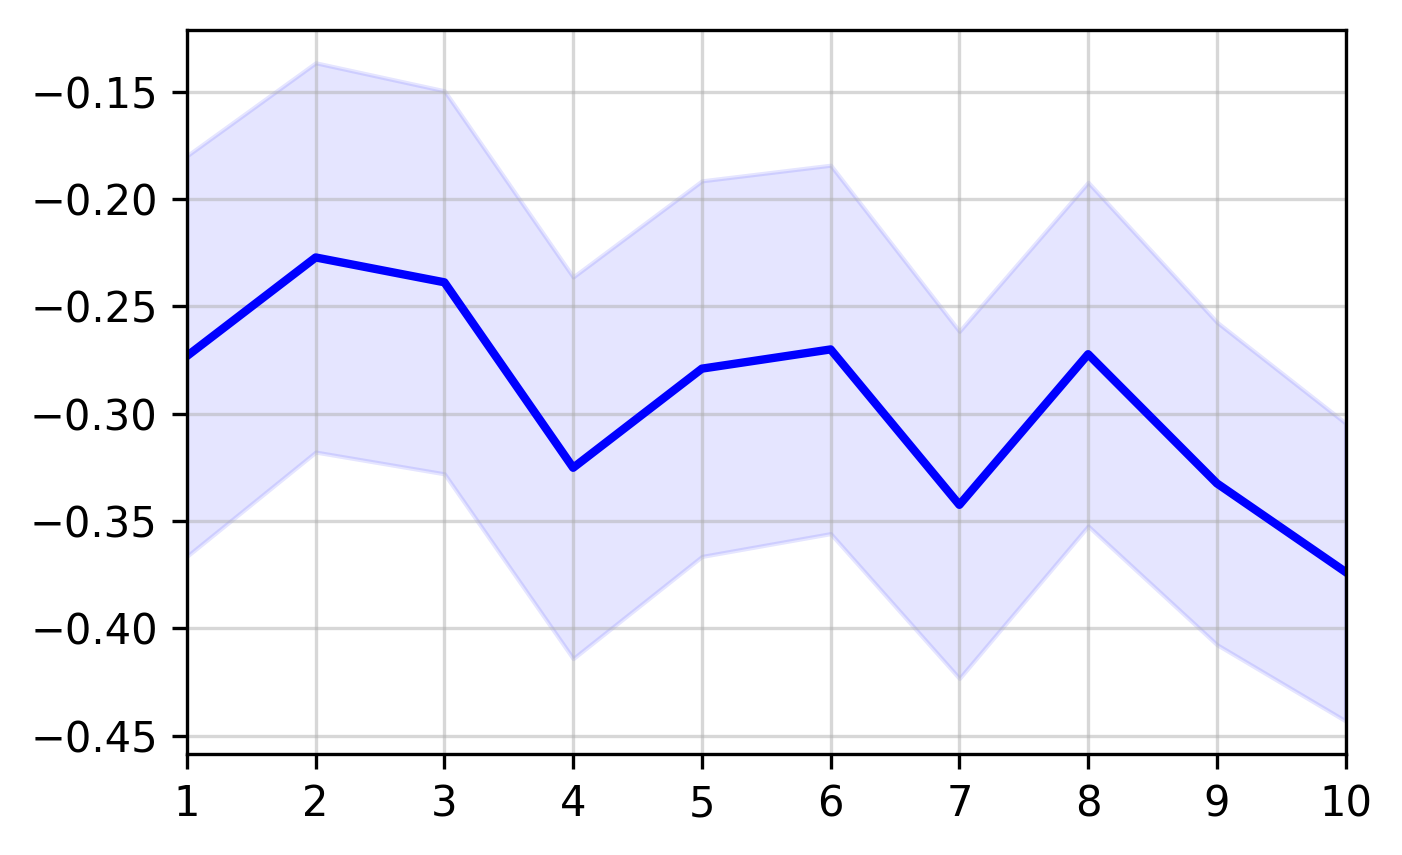

In [27]:

deciles = np.arange(1, 11)
plt.close()
plt.clf()
plt.figure(figsize=mpl.set_size())
plt.plot(deciles, dconsumption , label=r'$d \ln C$', color=colors['C'])
plt.fill_between(deciles, dconsumption_lb, dconsumption_ub ,
                 alpha=0.10, color=colors['C'])

plt.plot(deciles, dincome, label=r'$d \ln Y$', color=colors['Y'])
plt.xticks(deciles)
plt.fill_between(deciles, dincome_lb, dincome_ub ,
                 alpha=0.10, color=colors['Y'])

plt.ylabel('Percentage Change')
plt.xlabel('Income Decile')
plt.xticks(deciles)

plt.gca().set_ylim(top=0)

plt.legend()

if save:
    os.chdir(plotdir)
    plt.savefig('dincome_dconsumption_1994_1996_cugat.png')
plt.show()

<Figure size 640x480 with 0 Axes>

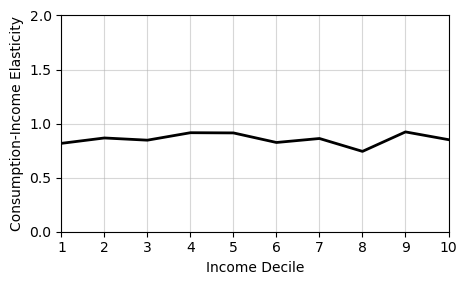

In [ ]:
deciles = np.arange(1, 11)
yticks = np.arange(0, 2.5, 0.5)
plt.close()
plt.clf()
plt.figure(figsize=mpl.set_size())
plt.plot(deciles, dconsumption / dincome)
plt.ylim(0, 2)
plt.yticks(yticks)
plt.xticks(deciles)
plt.ylabel('Consumption-Income Elasticity')

plt.xlabel('Income Decile')

if save:
    os.chdir(plotdir)
    plt.savefig('elasticity_1994_1996_cugat.png')
plt.show()

In [ ]:
consumption_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:        log_consumption   R-squared:                       0.586
Model:                            WLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     383.7
Date:                Fri, 01 Sep 2023   Prob (F-statistic):               0.00
Time:                        15:15:40   Log-Likelihood:                -10895.
No. Observations:               13070   AIC:                         2.189e+04
Df Residuals:                   13021   BIC:                         2.225e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               3.9569      0.082     48.436      0.000       3.797       4.117
C(sex)[T.2]                            -0.0056      0.017     -0.331      0.740      -0.039       0.027
C(education)[T.low]                    -0.1377      0.019     -7.091      0.000      -0.176      -0.100
C(education)[T.medium]                 -0.0782      0.019     -4.171      0.000      -0.115      -0.041
C(hh_size)[T.2]                         0.0186      0.024      0.790      0.429      -0.028       0.065
C(hh_size)[T.3]                         0.0766      0.022      3.487      0.000       0.034       0.120
C(hh_size)[T.4]                         0.1577      0.021      7.425      0.000       0.116       0.199
C(hh_size)[T.5]                         0.1636      0.022      7.602      0.000       0.121       0.206
C(hh_size)[T.6]                         0.2134      0.023      9.298      0.000       0.168       0.258
C(hh_size)[T.7]                         0.2413      0.025      9.563      0.000       0.192       0.291
C(hh_size)[T.8]                         0.2331      0.030      7.763      0.000       0.174       0.292
C(hh_size)[T.9]                         0.2185      0.035      6.278      0.000       0.150       0.287
C(hh_size)[T.10]                        0.3108      0.043      7.303      0.000       0.227       0.394
C(hh_size)[T.11]                        0.4401      0.053      8.295      0.000       0.336       0.544
C(hh_size)[T.12]                        0.3164      0.072      4.385      0.000       0.175       0.458
C(hh_size)[T.13]                        0.4743      0.083      5.737      0.000       0.312       0.636
C(hh_size)[T.14]                        0.3678      0.157      2.340      0.019       0.060       0.676
C(hh_size)[T.15]                        0.3918      0.161      2.433      0.015       0.076       0.707
C(hh_size)[T.16]                        0.0885      0.453      0.195      0.845      -0.799       0.976
C(hh_size)[T.17]                        0.4700      0.189      2.482      0.013       0.099       0.841
C(hh_size)[T.18]                        0.0450      1.458      0.031      0.975      -2.813       2.903
C(hh_size)[T.19]                        0.1272      0.914      0.139      0.889      -1.664       1.919
C(hh_size)[T.27]                        0.6985      1.940      0.360      0.719      -3.105       4.502
C(location_size)[T.2]                   0.0126      0.011      1.170      0.242      -0.009       0.034
C(location_size)[T.3]                  -0.0257      0.012     -2.211      0.027      -0.048      -0.003
C(decile)[T.2]                          0.4143      0.026     16.088      0.000       0.364       0.465
C(decile)[T.3]                          0.5696      0.026     21.65

In [ ]:
gamma = [str(x) for x in np.arange(1, 11)]
gamma = ['post[T.True]:C(decile)[' + x + ']' for x in gamma]
include = [
    'post[T.true]:C(education)[T.low]',
    'post[T.true]:C(education)[T.medium]',
    'post[T.true]:C(sex)[T.2]'
]
include += gamma
include

['C(sex)[T.2]',
 'C(education)[T.low]',
 'C(education)[T.medium]',
 'age',
 'I(age ** 2)',
 'post[T.True]:C(decile)[1]',
 'post[T.True]:C(decile)[2]',
 'post[T.True]:C(decile)[3]',
 'post[T.True]:C(decile)[4]',
 'post[T.True]:C(decile)[5]',
 'post[T.True]:C(decile)[6]',
 'post[T.True]:C(decile)[7]',
 'post[T.True]:C(decile)[8]',
 'post[T.True]:C(decile)[9]',
 'post[T.True]:C(decile)[10]']

In [ ]:
rename = {
    'post[T.true]:C(education)[T.low]':'\\text{Post} \\times \\text{Education: low}',
    'post[T.true]:C(education)[T.medium]':'\\text{Post} \\times \\text{Education: medium}'
    'post[T.true]:C(sex)[T.2]':'\\text{Post} \\times \\text{Female}'
}
for x in np.arange(1, 11):
    id = 'post[T.True]:C(decile)[' + str(x) + ']'
    value = '$\\text{Post} \\times \\text{Decile}(' + str(x) + ')$'
    rename[id] = value
rename

{'C(sex)[T.2]': 'Female',
 'C(education)[T.low]': 'Education: low',
 'C(education)[T.medium]': 'Education: medium',
 'age': 'Age',
 'I(age ** 2)': '$\\text{Age}^2$',
 'post[T.True]:C(decile)[1]': '$\\text{Post} \\times \\text{Decile}(1)$',
 'post[T.True]:C(decile)[2]': '$\\text{Post} \\times \\text{Decile}(2)$',
 'post[T.True]:C(decile)[3]': '$\\text{Post} \\times \\text{Decile}(3)$',
 'post[T.True]:C(decile)[4]': '$\\text{Post} \\times \\text{Decile}(4)$',
 'post[T.True]:C(decile)[5]': '$\\text{Post} \\times \\text{Decile}(5)$',
 'post[T.True]:C(decile)[6]': '$\\text{Post} \\times \\text{Decile}(6)$',
 'post[T.True]:C(decile)[7]': '$\\text{Post} \\times \\text{Decile}(7)$',
 'post[T.True]:C(decile)[8]': '$\\text{Post} \\times \\text{Decile}(8)$',
 'post[T.True]:C(decile)[9]': '$\\text{Post} \\times \\text{Decile}(9)$',
 'post[T.True]:C(decile)[10]': '$\\text{Post} \\times \\text{Decile}(10)$'}

In [ ]:
star = Stargazer([consumption_model, income_model])
star.covariate_order(include)
star.custom_columns(['Consumption', 'Income'])
star.rename_covariates(rename)
star.add_line('Deciles', ['$\\checkmark$' for x in np.arange(2)])
star.add_line('Controls', ['$\\checkmark$' for x in np.arange(2)])
star.add_line('$\\text{Post} \\times \\text{Controls}$', ['$\\checkmark$' for x in np.arange(2)])
#Z = 'age + I(age**2) + C(sex) + C(education) + C(hh_size)  + C(location_size) + C(decile)'
star

In [ ]:
def strip_table(str):
    str = str.removeprefix('\\begin{table}[!htbp] ')
    str = str.removesuffix('\n\\end{table}')
    return str
output = strip_table(star.render_latex())

os.chdir(plotdir)
with open('enigh_regression.tex', 'w') as textfile:
    textfile.write(output)

'\\centering\n\\begin{tabular}{@{\\extracolsep{5pt}}lcc}\n\\\\[-1.8ex]\\hline\n\\hline \\\\[-1.8ex]\n\\\\[-1.8ex] & \\multicolumn{1}{c}{Consumption} & \\multicolumn{1}{c}{Income}  \\\\\n\\\\[-1.8ex] & (1) & (2) \\\\\n\\hline \\\\[-1.8ex]\n Female & -0.006$^{}$ & -0.008$^{}$ \\\\\n& (0.017) & (0.008) \\\\\n Education: low & -0.138$^{***}$ & -0.055$^{***}$ \\\\\n& (0.019) & (0.009) \\\\\n Education: medium & -0.078$^{***}$ & -0.039$^{***}$ \\\\\n& (0.019) & (0.009) \\\\\n Age & -0.005$^{}$ & -0.003$^{}$ \\\\\n& (0.004) & (0.002) \\\\\n $\\text{Age}^2$ & 0.000$^{}$ & 0.000$^{*}$ \\\\\n& (0.000) & (0.000) \\\\\n $\\text{Post} \\times \\text{Decile}(1)$ & -0.288$^{***}$ & -0.352$^{***}$ \\\\\n& (0.036) & (0.016) \\\\\n $\\text{Post} \\times \\text{Decile}(2)$ & -0.269$^{***}$ & -0.310$^{***}$ \\\\\n& (0.035) & (0.016) \\\\\n $\\text{Post} \\times \\text{Decile}(3)$ & -0.256$^{***}$ & -0.303$^{***}$ \\\\\n& (0.035) & (0.016) \\\\\n $\\text{Post} \\times \\text{Decile}(4)$ & -0.272$^{***}$ & 

In [ ]:
consumption_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:        log_consumption   R-squared:                       0.586
Model:                            WLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     383.7
Date:                Fri, 01 Sep 2023   Prob (F-statistic):               0.00
Time:                        15:15:40   Log-Likelihood:                -10895.
No. Observations:               13070   AIC:                         2.189e+04
Df Residuals:                   13021   BIC:                         2.225e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               3.9569      0.082     48.436      0.000       3.797       4.117
C(sex)[T.2]                            -0.0056      0.017     -0.331      0.740      -0.039       0.027
C(education)[T.low]                    -0.1377      0.019     -7.091      0.000      -0.176      -0.100
C(education)[T.medium]                 -0.0782      0.019     -4.171      0.000      -0.115      -0.041
C(hh_size)[T.2]                         0.0186      0.024      0.790      0.429      -0.028       0.065
C(hh_size)[T.3]                         0.0766      0.022      3.487      0.000       0.034       0.120
C(hh_size)[T.4]                         0.1577      0.021      7.425      0.000       0.116       0.199
C(hh_size)[T.5]                         0.1636      0.022      7.602      0.000       0.121       0.206
C(hh_size)[T.6]                         0.2134      0.023      9.298      0.000       0.168       0.258
C(hh_size)[T.7]                         0.2413      0.025      9.563      0.000       0.192       0.291
C(hh_size)[T.8]                         0.2331      0.030      7.763      0.000       0.174       0.292
C(hh_size)[T.9]                         0.2185      0.035      6.278      0.000       0.150       0.287
C(hh_size)[T.10]                        0.3108      0.043      7.303      0.000       0.227       0.394
C(hh_size)[T.11]                        0.4401      0.053      8.295      0.000       0.336       0.544
C(hh_size)[T.12]                        0.3164      0.072      4.385      0.000       0.175       0.458
C(hh_size)[T.13]                        0.4743      0.083      5.737      0.000       0.312       0.636
C(hh_size)[T.14]                        0.3678      0.157      2.340      0.019       0.060       0.676
C(hh_size)[T.15]                        0.3918      0.161      2.433      0.015       0.076       0.707
C(hh_size)[T.16]                        0.0885      0.453      0.195      0.845      -0.799       0.976
C(hh_size)[T.17]                        0.4700      0.189      2.482      0.013       0.099       0.841
C(hh_size)[T.18]                        0.0450      1.458      0.031      0.975      -2.813       2.903
C(hh_size)[T.19]                        0.1272      0.914      0.139      0.889      -1.664       1.919
C(hh_size)[T.27]                        0.6985      1.940      0.360      0.719      -3.105       4.502
C(location_size)[T.2]                   0.0126      0.011      1.170      0.242      -0.009       0.034
C(location_size)[T.3]                  -0.0257      0.012     -2.211      0.027      -0.048      -0.003
C(decile)[T.2]                          0.4143      0.026     16.088      0.000       0.364       0.465
C(decile)[T.3]                          0.5696      0.026     21.65

In [ ]:
years = np.sort(df.Y.unique())

income_by_decile = pd.DataFrame(columns=years, index=np.arange(1, 11))
consumption_by_decile = pd.DataFrame(columns=years, index=np.arange(1, 11))

for year in years:
        income      = utils.indicator_by_decile(df.query('Y == @year'), 'log_income', 'log_income', 'weight')
        consumption = utils.indicator_by_decile(df.query('Y == @year'), 'log_income', 'log_consumption', 'weight')

        income_by_decile[year]      = income
        consumption_by_decile[year] = consumption

income_by_decile

def elasticity(y1, y2, income_by_decile=income_by_decile, consumption_by_decile=consumption_by_decile):
        e = (consumption_by_decile[y2] - consumption_by_decile[y1]) / (income_by_decile[y2] - income_by_decile[y1])
        return e